In [5]:
# import python modules
import plumed
import matplotlib.pyplot as plt
import numpy as np

# Plots setup 
from matplotlib import rc
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')


plt.rcParams.update({"font.size": 16})
plw = 0.6
pcs = 3
pms = 3
bfillc = [0.9,0.9,0.9]
plt.rcParams["figure.figsize"] = (10,5)

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)



## Exercise 1

Compute the number of liquid-like LJ atoms in the simulation box by using ```plumed driver``` with the plumed  file: 

```
# LIQUID-like atoms
lq: COORDINATIONNUMBER SPECIES=1-10000 SWITCH={CUBIC D_0=0.45  D_MAX=0.55} MORE_THAN={RATIONAL R_0=5.0 D_MAX=10.0}

PRINT ARG=lq.morethan STRIDE=1 FILE=nliquid.dat
```
Import the data as a pandas dataset as: 

In [3]:
# import nliquid.dat file as pandas dataset
data=plumed.read_as_pandas("../Ex1/nliquid.dat");
# print dataset' column names
data.columns

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/Applications/anaconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.dylib" +++


Index(['time', 'lq.morethan'], dtype='object')

Produce a plot of the number of liquid-like LJ atoms in the system, as a function of simulation time: 

#### Number of liquid-like LJ atoms

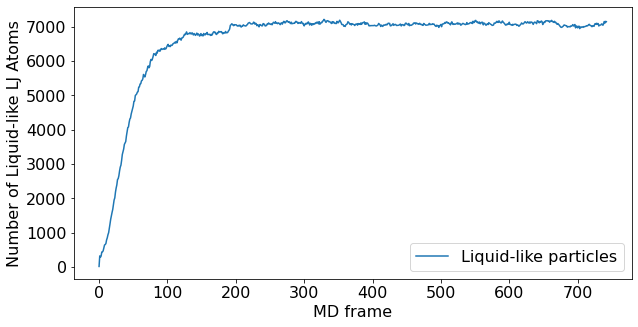

In [6]:
# plot time serie of gyration radius (r) and distance (d)
plt.plot(data['time'],data['lq.morethan'], label="Liquid-like particles")
# x-y axis labels
plt.xlabel("MD frame")
plt.ylabel("Number of Liquid-like LJ Atoms")
plt.legend();

### Do it on your own: 

_Using other MultiColvar keywords can you count the number of atoms on the surface of the clusters forming in this trajectory? Can you estimate how the surface to volume ratio of the droplets forming in the system changes directly within PLUMED?_

The number of LJ atoms on the surface of clusters has an intermediate coordination number between the threshold of 5 nearest neighbours and a lower bound of the number of neares neighbours in the bulk of the liquid phase (here taken as equal to 8). 

Using then the multicolvar action ```BETWEEN```, paired with ```COORDINATIONNUMBER``` allows to estimate the number of LJ atoms satisfying this constraint. 

```
surface: COORDINATIONNUMBER SPECIES=1-10000 SWITCH={CUBIC D_0=0.45  D_MAX=0.55} BETWEEN={GAUSSIAN LOWER=5.0 UPPER=8.0}
```
The ratio of atoms exposed to the surface with respect to the total number of atoms in the dense liquid phase can be computed with ```MATHEVAL``` as: 
```
ratio: MATHEVAL ARG=bulk.morethan,surface.between FUNC=y/x PERIODIC=NO 
```
The final analysis plumed file will look something like: 

```
bulk: COORDINATIONNUMBER SPECIES=1-10000 SWITCH={CUBIC D_0=0.45  D_MAX=0.55} MORE_THAN={RATIONAL R_0=8.0 D_MAX=12.0}

surface: COORDINATIONNUMBER SPECIES=1-10000 SWITCH={CUBIC D_0=0.45  D_MAX=0.55} BETWEEN={GAUSSIAN LOWER=5.0 UPPER=8.0}

ratio: MATHEVAL ARG=bulk.morethan,surface.between FUNC=y/x PERIODIC=NO 

PRINT ARG=bulk.morethan,surface.between,ratio STRIDE=1 FILE=nliquid_ToYO.dat
```
The dataset can then be imported and plotted as follows: 

#### Bulk and surface LJ atoms

In [8]:
# import COLVAR file as pandas dataset
data=plumed.read_as_pandas("../Ex1/nliquid_ToYO.dat");
# print pandas dataset
data.columns

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/Applications/anaconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.dylib" +++


Index(['time', 'bulk.morethan', 'surface.between', 'ratio'], dtype='object')

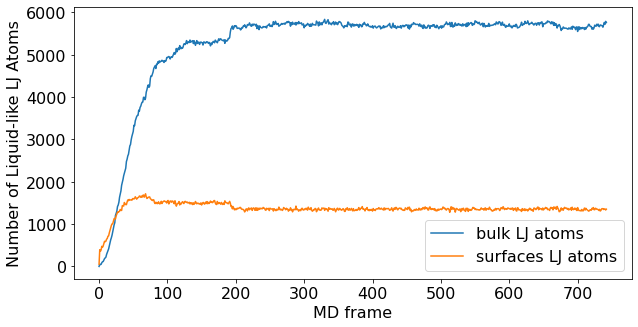

In [9]:
# plot time serie of gyration radius (r) and distance (d)
plt.plot(data['time'],data['bulk.morethan'], label="bulk LJ atoms")
plt.plot(data['time'],data['surface.between'], label="surfaces LJ atoms")
# x-y axis labels
plt.xlabel("MD frame")
plt.ylabel("Number of Liquid-like LJ Atoms")
plt.legend();

#### ~Surface to volume ratio in time

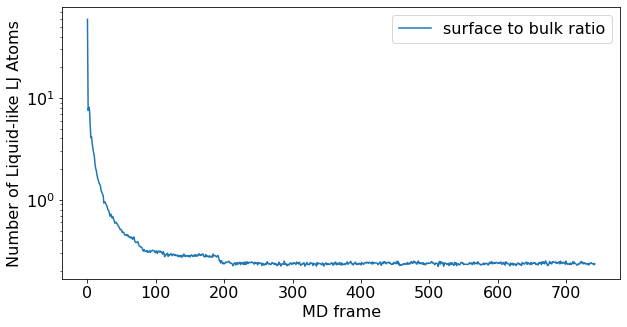

In [10]:
Ratio=data['ratio'];

# plot time serie of gyration radius (r) and distance (d)
plt.yscale("log")  
plt.plot(data['time'],data['ratio'], label="surface to bulk ratio")

# x-y axis labels
plt.xlabel("MD frame")
plt.ylabel("Number of Liquid-like LJ Atoms")
plt.legend();

#### Surface to Volume Ratio vs number of liquid-like LJ atoms

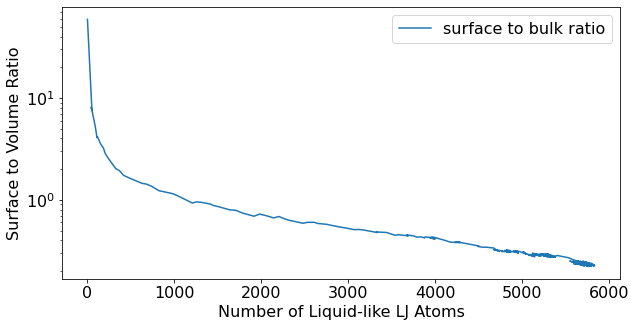

In [11]:
# plot time serie of gyration radius (r) and distance (d)
plt.yscale("log")  
plt.plot(data['bulk.morethan'],data['ratio'], label="surface to bulk ratio")

# x-y axis labels
plt.ylabel("Surface to Volume Ratio")
plt.xlabel("Number of Liquid-like LJ Atoms")
plt.legend();

## Exercise 2

Here we analyse the clusters that form during the system' evolution, and plot their number, and size.

To this aim ```plumed driver``` can be used with the following input file computing the number of clusters containing 5 or more liquid-like LJ_atoms, and the size of the four larges clusters as:

```
# Identify liquid-like atoms
lq: COORDINATIONNUMBER SPECIES=1-10000 SWITCH={CUBIC D_0=0.45  D_MAX=0.55} MORE_THAN={RATIONAL R_0=5.0 D_MAX=10.0}

# Define a contact matrix & perfom DFS clustering 
cm: CONTACT_MATRIX ATOMS=lq  SWITCH={CUBIC D_0=0.45  D_MAX=0.55}                      
dfs: DFSCLUSTERING MATRIX=cm       

# Compute the size of the four largest clusters
cluster_1: CLUSTER_NATOMS CLUSTERS=dfs CLUSTER=1 
cluster_2: CLUSTER_NATOMS CLUSTERS=dfs CLUSTER=2
cluster_3: CLUSTER_NATOMS CLUSTERS=dfs CLUSTER=3
cluster_4: CLUSTER_NATOMS CLUSTERS=dfs CLUSTER=4

# Compute the number of clusters  
nclust: CLUSTER_DISTRIBUTION CLUSTERS=dfs MORE_THAN={GAUSSIAN D_0=4.95 R_0=0.01 D_MAX=4.99}

# PRINT to file
PRINT ARG=lq.morethan,nclust.*,cluster_1,cluster_2,cluster_3,cluster_4 STRIDE=1  FILE=clusters.dat

FLUSH STRIDE=1
```




In [12]:
# import clusters.dat file as pandas dataset
data=plumed.read_as_pandas("../Ex2/clusters.dat");
# print column names of the pandas dataset
data.columns

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/Applications/anaconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.dylib" +++


Index(['time', 'lq.morethan', 'nclust.morethan', 'nclust20.morethan',
       'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4'],
      dtype='object')

#### Number of Clusters

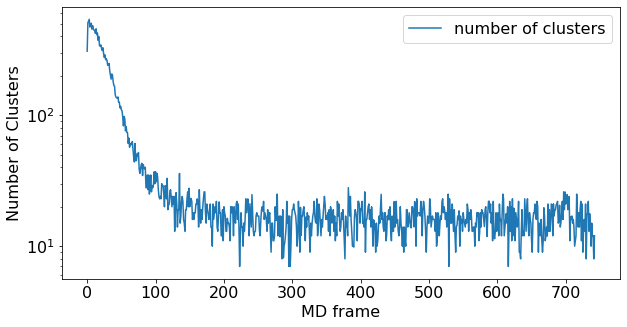

In [ ]:
# plot time serie of the number of clusters of 5 or more LJ atoms. 
plt.yscale("log") 
plt.plot(data['time'],data['nclust.morethan'], label="number of clusters")
# x-y axis labels
plt.xlabel("MD frame")
plt.ylabel("Number of Clusters")
plt.legend();

#### Growth of the largest cluster

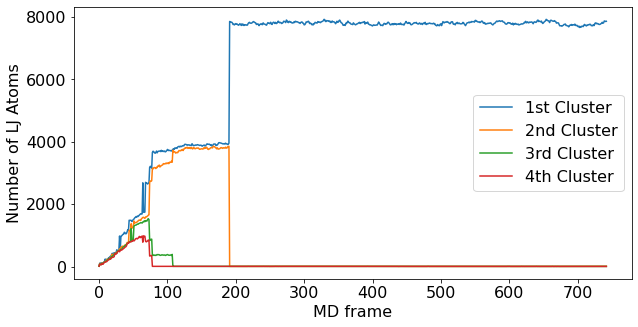

In [14]:
# plot time serie of the size of the 4 largest clusters
plt.plot(data['time'],data['cluster_1'], label="1st Cluster")
plt.plot(data['time'],data['cluster_2'], label="2nd Cluster")
plt.plot(data['time'],data['cluster_3'], label="3rd Cluster")
plt.plot(data['time'],data['cluster_4'], label="4th Cluster")
# x-y axis labels
plt.xlabel("MD frame")
plt.ylabel("Number of LJ Atoms")
plt.legend();

#### Size of the largest cluster

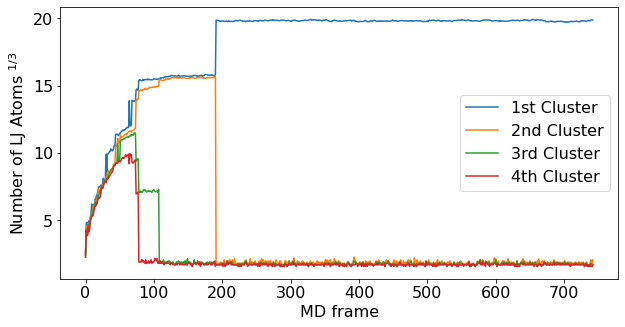

In [16]:
# plot time serie of the ~radius of the 4 largest clusters
plt.plot(data['time'],np.power(data['cluster_1'],1/3), label="1st Cluster")
plt.plot(data['time'],np.power(data['cluster_2'],1/3), label="2nd Cluster")
plt.plot(data['time'],np.power(data['cluster_3'],1/3), label="3rd Cluster")
plt.plot(data['time'],np.power(data['cluster_4'],1/3), label="4th Cluster")
# x-y axis labels
plt.xlabel("MD frame")
plt.ylabel("Number of LJ Atoms $^{1/3}$")
plt.legend();

### Do it on your own

_Modifying the setup above, can you compute the number of clusters with a size larger than 20 LJ particles?_

To this aim it is sufficient to edit the plumed file to include a new criterion for the calculation of the number of clusters, using the ```CLUSTER_DISTRIBUTION``` statement of ```DFSCLUSTERING```: 

```
# Identify liquid-like atoms
lq: COORDINATIONNUMBER SPECIES=1-10000 SWITCH={CUBIC D_0=0.45  D_MAX=0.55} MORE_THAN={RATIONAL R_0=5.0 D_MAX=10.0}

# Define a contact matrix & perfom DFS clustering 
cm: CONTACT_MATRIX ATOMS=lq  SWITCH={CUBIC D_0=0.45  D_MAX=0.55}                      
dfs: DFSCLUSTERING MATRIX=cm       

# Compute the size of the four largest clusters
cluster_1: CLUSTER_NATOMS CLUSTERS=dfs CLUSTER=1 
cluster_2: CLUSTER_NATOMS CLUSTERS=dfs CLUSTER=2
cluster_3: CLUSTER_NATOMS CLUSTERS=dfs CLUSTER=3
cluster_4: CLUSTER_NATOMS CLUSTERS=dfs CLUSTER=4

# Compute the number of clusters  
nclust: CLUSTER_DISTRIBUTION CLUSTERS=dfs MORE_THAN={GAUSSIAN D_0=4.95 R_0=0.01 D_MAX=4.99}

# Compute the number of clusters
nclust20: CLUSTER_DISTRIBUTION CLUSTERS=dfs MORE_THAN={GAUSSIAN D_0=19.95 R_0=0.01 D_MAX=19.99}


# PRINT to file
PRINT ARG=lq.morethan,nclust.*,nclust20.*,cluster_1,cluster_2,cluster_3,cluster_4 STRIDE=1  FILE=clusters.dat

FLUSH STRIDE=1
```

The number of clusters larger than 20 LJ atoms converges to one, with infrequent fluctuations. This means that the background cluster size distribution, coexisting with the steady-state droplet decays to zero below n=20. 



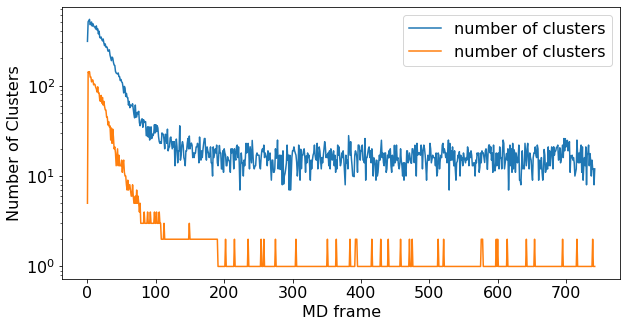

In [17]:
# plot time serie of gyration radius (r) and distance (d)
plt.yscale("log") 
plt.plot(data['time'],data['nclust.morethan'], label="number of clusters")
plt.plot(data['time'],data['nclust20.morethan'], label="number of clusters")
# x-y axis labels
plt.xlabel("MD frame")
plt.ylabel("Number of Clusters")
plt.legend();

#### Surface to Volume ratio vs number of clusters (n>20 LJ atoms)

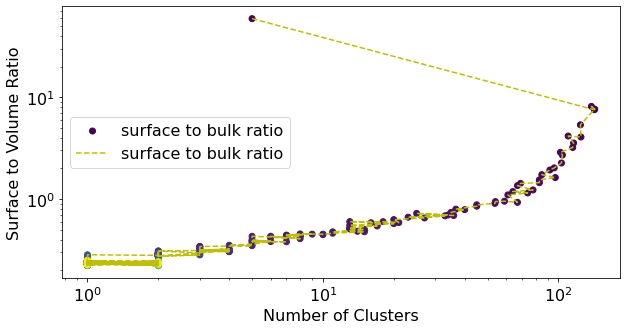

In [18]:
# plot time serie of gyration radius (r) and distance (d)
plt.xscale("log") 
plt.yscale("log") 
plt.scatter(data['nclust20.morethan'],Ratio,c=data['time'], label="surface to bulk ratio")
plt.plot(data['nclust20.morethan'],Ratio,'y--', label="surface to bulk ratio")

# x-y axis labels
plt.ylabel("Surface to Volume Ratio")
plt.xlabel("Number of Clusters")
plt.legend();

## Exercise 3

Here we use PLUMED to establish a steady-state, out-of-equilibrium diffusive flux with C$\mu$MD. 

To this aim we setup a plumed file containing the ```CMUMD``` statement, using an asymmetric concentration control: 

```
# Define groups of atoms
LJ: GROUP ATOMS=1-1000:1 

# Provide parameters for the CV
left:  CMUMD GROUP=lj NSV=1 FIXED=0.5 DCR=0.25 CRSIZE=0.1 WF=0.0001  ASYMM=-1 NINT=0.1 NZ=291
right:  CMUMD GROUP=lj NSV=1 FIXED=0.5 DCR=0.25 CRSIZE=0.1 WF=0.0001  ASYMM=1 NINT=0.1 NZ=291

# CmuMD is implemented as a restraint on the densities of species in CR
rleft:  RESTRAINT ARG=left AT=1.4 KAPPA=1000.0 
rright: RESTRAINT ARG=right AT=0.05 KAPPA=2000.0 

# Report the densities and bias
PRINT ...
ARG=left,right,rleft.bias,rright.bias
STRIDE=10
FILE=CMUMD_log
... PRINT
```


In [19]:
# import CMUMD_log file as pandas dataset
data=plumed.read_as_pandas("../Ex3/CMUMD_log");
# print pandas dataset
data.columns

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/Applications/anaconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.dylib" +++


Index(['time', 'left', 'right', 'rleft.bias', 'rright.bias'], dtype='object')

#### Control Regions Composition

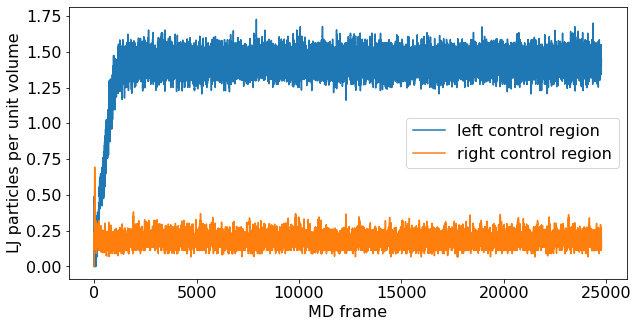

In [20]:
# plot 
plt.plot(data['time'],data['left'], label="left control region")
plt.plot(data['time'],data['right'], label="right control region")

# x-y axis labels
plt.xlabel("MD frame")
plt.ylabel("LJ particles per unit volume")
plt.legend();

#### Restraint potential

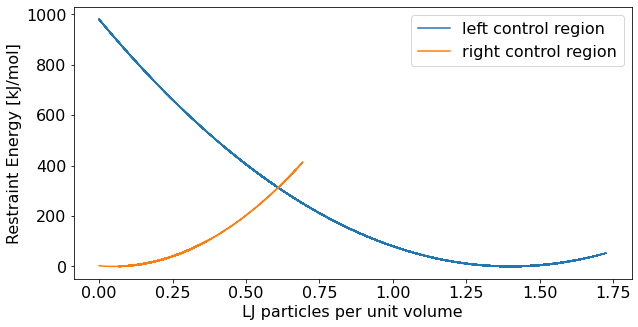

In [21]:
# plot 
plt.plot(data['left'],data['rleft.bias'], label="left control region")
plt.plot(data['right'],data['rright.bias'], label="right control region")

# x-y axis labels
plt.xlabel("LJ particles per unit volume")
plt.ylabel("Restraint Energy [kJ/mol]")
plt.legend();

### Do it on your own

_

In order to plot the density profile,  one can take advantage of the ```DENSITY``` and ```MULTICOLVARDENS``` statements: 

```
REF: FIXEDATOM AT=0,0,14 

dens: DENSITY SPECIES=1-1000 

grid: MULTICOLVARDENS ORIGIN=REF DATA=dens DIR=z NBINS=100 BANDWIDTH=0.05 STRIDE=500 

DUMPGRID GRID=grid STRIDE=500 FILE=density_profile 
```

Different driving forces can be imposed by setting a different target density in the high concentration control region. This is achieved by modifying the ```RESTRAINT``` action in the ```cmumd.dat``` plumed file, by setting a different ```AT=new_value``` 

```
rleft:  RESTRAINT ARG=left AT=2.0 KAPPA=10000.0 
```


In [25]:
# Box information
lz=28.00000
lx=4
ly=4.
boundaries=np.array([-0.35,-0.25,0.25,0.35])

In [27]:
# import Density Profiles
data=plumed.read_as_pandas("../Ex3/density_profile");
data_1=plumed.read_as_pandas("../Ex3/density_profile_0p5");
data_2=plumed.read_as_pandas("../Ex3/density_profile_1p0");

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/Applications/anaconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.dylib" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/Applications/anaconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.dylib" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/Applications/anaconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.dylib" +++


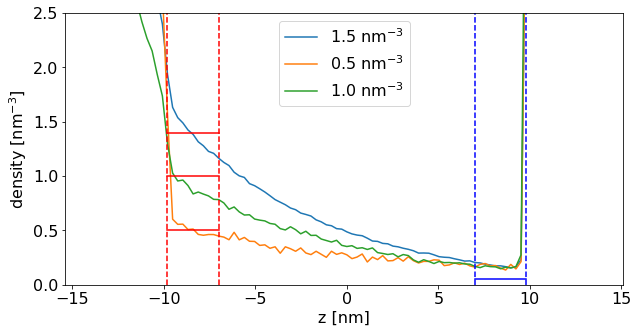

In [28]:
# plot Density Profiles
data.columns
plt.plot((data['z']),data['dens.dens']/(lx*ly), label="1.5 nm$^{-3}$")
plt.plot((data_1['z']),data_1['dens.dens']/(lx*ly), label="0.5 nm$^{-3}$")
plt.plot((data_2['z']),data_2['dens.dens']/(lx*ly), label="1.0 nm$^{-3}$")

plt.plot(np.array([lz*boundaries[0],lz*boundaries[0]]),[0,10],'r--')
plt.plot(np.array([lz*boundaries[1],lz*boundaries[1]]),[0,10],'r--')
plt.plot(np.array([lz*boundaries[2],lz*boundaries[2]]),[0,10],'b--')
plt.plot(np.array([lz*boundaries[3],lz*boundaries[3]]),[0,10],'b--')

plt.plot(np.array([lz*boundaries[0],lz*boundaries[1]]),[1.4,1.4],'r-')
plt.plot(np.array([lz*boundaries[0],lz*boundaries[1]]),[1.0,1.0],'r-')
plt.plot(np.array([lz*boundaries[0],lz*boundaries[1]]),[0.5,0.5],'r-')
plt.plot(np.array([lz*boundaries[2],lz*boundaries[3]]),[0.05,0.05],'b-')
                
plt.ylim([0, 2.50])    
# x-y axis labels
plt.xlabel("z [nm]")
plt.ylabel("density [nm$^{-3}$]")
plt.legend();

## Exercise 4

In [ ]:
# import COLVAR file as pandas dataset
data=plumed.read_as_pandas("./Ex4/CMUMD_log");
# print pandas dataset
data.columns

In [ ]:
# plot time serie of gyration radius (r) and distance (d)
plt.plot(data['time'],data['left'], label="left control region")
plt.plot(data['time'],data['right'], label="right control region")

# x-y axis labels
plt.xlabel("MD frame")
plt.ylabel("LJ particles per unit volume [nm$^{-3}$]")
plt.legend();

In [ ]:
# plot time serie of gyration radius (r) and distance (d)
plt.plot(data['left'],data['rleft.bias'], label="left control region")
plt.plot(data['right'],data['rright.bias'], label="right control region")

# x-y axis labels
plt.xlabel("LJ particles per unit volume [nm$^{-3}]$")
plt.ylabel("Restraint Energy [kJ/mol]")
plt.legend();

### Do it on your own

_Setup and run CMUMD simulations for the LJ slab system at varying CR concentrations._ 
_Use the multicolvar-based approach discussed in Ex1 to follow the condensation process._  
_Use the graph-based approach discussed in Ex2 to follow the condensation process._
_Monitor the density profile across the simulation box._ 


In order to postprocess one can combine the solutions of previous Exercises, note that here it comes in handy to use the ```AROUND``` action to compute multicolvars in specific regions of the simulation box:  


```
REF: FIXEDATOM AT=0,0,11

lq: COORDINATIONNUMBER SPECIES=1001-2000 SWITCH={CUBIC D_0=0.45  D_MAX=0.55} MORE_THAN={RATIONAL R_0=5.0 D_MAX=5.1}

ads: AROUND DATA=lq ATOM=REF ZLOWER=-3.0 ZUPPER=3.0 SIGMA=0.1 MORE_THAN={RATIONAL R_0=5.0 D_MAX=5.1}
res1: AROUND DATA=lq ATOM=REF ZLOWER=10.0 ZUPPER=11.0 SIGMA=0.1 MORE_THAN={RATIONAL R_0=5.0 D_MAX=5.1}
res2: AROUND DATA=lq ATOM=REF ZLOWER=-11.0 ZUPPER=-10.0 SIGMA=0.1 MORE_THAN={RATIONAL R_0=5.0 D_MAX=5.1}

res: MATHEVAL ARG=res1.morethan,res2.morethan FUNC=x+y PERIODIC=NO


# Define a contact matrix & perfom DFS clustering 
cm: CONTACT_MATRIX ATOMS=ads  SWITCH={CUBIC D_0=0.45  D_MAX=0.55}                      
dfs: DFSCLUSTERING MATRIX=cm       

# Compute the size of the four largest clusters
cluster_1: CLUSTER_NATOMS CLUSTERS=dfs CLUSTER=1 
cluster_2: CLUSTER_NATOMS CLUSTERS=dfs CLUSTER=2

# Compute the number of clusters
nclust: CLUSTER_DISTRIBUTION CLUSTERS=dfs MORE_THAN={GAUSSIAN D_0=19.95 R_0=0.01 D_MAX=19.99}

dens1: DENSITY SPECIES=1-1000 
dens2: DENSITY SPECIES=1001-2000 

slab: MULTICOLVARDENS ORIGIN=REF DATA=dens1 DIR=z NBINS=100 BANDWIDTH=0.25 STRIDE=500 
grid: MULTICOLVARDENS ORIGIN=REF DATA=dens2 DIR=z NBINS=100 BANDWIDTH=0.25 STRIDE=500 

DUMPGRID GRID=slab STRIDE=500 FILE=slab_profile_ToYO
DUMPGRID GRID=grid STRIDE=500 FILE=density_profile_ToYO

PRINT ARG=lq.morethan,ads.*,res,nclust.*,cluster_1,cluster_2 STRIDE=1  FILE=slab_analysis_ToYO.dat
```

In [34]:
# import COLVAR file as pandas dataset
data=plumed.read_as_pandas("../Ex4/slab_analysis_ToYO.dat");
# print pandas dataset
data.columns

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/Applications/anaconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.dylib" +++


Index(['time', 'lq.morethan', 'ads.morethan', 'res', 'nclust.morethan',
       'cluster_1', 'cluster_2'],
      dtype='object')

#### Analysis of the condensation process

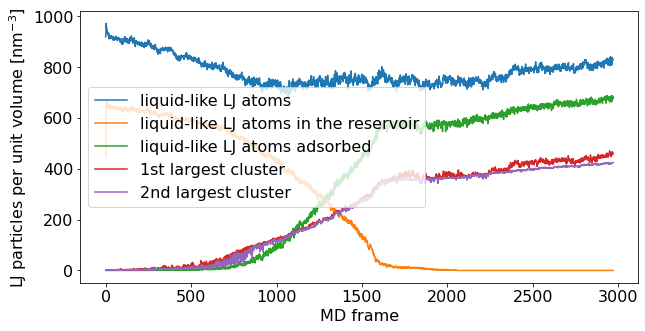

In [37]:
# plot time serie of gyration radius (r) and distance (d)
plt.plot(data['time'],data['lq.morethan'], label="liquid-like LJ atoms")
plt.plot(data['time'],data['res'], label="liquid-like LJ atoms in the reservoir")
plt.plot(data['time'],data['ads.morethan'], label="liquid-like LJ atoms adsorbed")
plt.plot(data['time'],data['cluster_1'], label="1st largest cluster")
plt.plot(data['time'],data['cluster_2'], label="2nd largest cluster")

# x-y axis labels
plt.xlabel("MD frame")
plt.ylabel("LJ particles per unit volume [nm$^{-3}$]")
plt.legend();

#### Analysis of the Density Profile

In [53]:
# import density profile file as pandas dataset
data=plumed.read_as_pandas("../Ex4/analysis.2.slab_profile_ToYO");
data1=plumed.read_as_pandas("../Ex4/analysis.2.density_profile_ToYO");
data2=plumed.read_as_pandas("../Ex4/analysis.3.density_profile_ToYO");
data1.columns

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/Applications/anaconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.dylib" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/Applications/anaconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.dylib" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/Applications/anaconda3/envs/plumed-masterclass-2022/lib/libplumedKernel.dylib" +++


Index(['z', 'dens2.dens', 'ddens2.dens_z'], dtype='object')

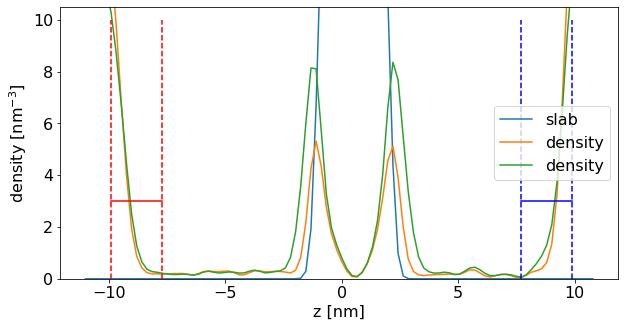

In [54]:
lz=22.00000
lx=4
ly=4.
boundaries=np.array([-0.45,-0.35,0.35,0.45])

plt.plot((data['z']),data['dens1.dens']/(lx*ly), label="slab")
plt.plot((data1['z']),data1['dens2.dens']/(lx*ly), label="density")
plt.plot((data2['z']),data2['dens2.dens']/(lx*ly), label="density")

plt.plot(np.array([lz*boundaries[0],lz*boundaries[0]]),[0,10],'r--')
plt.plot(np.array([lz*boundaries[1],lz*boundaries[1]]),[0,10],'r--')
plt.plot(np.array([lz*boundaries[2],lz*boundaries[2]]),[0,10],'b--')
plt.plot(np.array([lz*boundaries[3],lz*boundaries[3]]),[0,10],'b--')

plt.plot(np.array([lz*boundaries[0],lz*boundaries[1]]),[3,3],'r-')
plt.plot(np.array([lz*boundaries[2],lz*boundaries[3]]),[3,3],'b-')
                
plt.ylim([0, 10.50])    
# x-y axis labels
plt.xlabel("z [nm]")
plt.ylabel("density [nm$^{-3}$]")
plt.legend();